## **Water Leak Prediction Using Deep Learning**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Configuration**

**Load SCADA Data**

In [3]:
SCADA_FILE = 'Dataset/2018_SCADA.xlsx'
LEAKAGES_FILE = "Dataset/2018_Leakages.csv"

scada_data = pd.read_excel(SCADA_FILE, sheet_name=None, index_col=0)
# access each sheet in the scada file
pressure_df = scada_data['Pressures (m)']
flow_df = scada_data['Flows (m3_h)']
level_df = scada_data['Levels (m)']
arms_df = scada_data['Demands (L_h)'] # aggregated metered readings

print("Loaded SCADA data from Excel sheets.")

Loaded SCADA data from Excel sheets.


In [4]:
# Convert index to datetime objects for time series operations
pressure_df.index = pd.to_datetime(pressure_df.index)
flow_df.index = pd.to_datetime(flow_df.index)
level_df.index = pd.to_datetime(level_df.index)
arms_df.index = pd.to_datetime(arms_df.index)

**Load Leakage Data (New Format: Flow Rates)**

In [5]:
leakages_df = pd.read_csv(LEAKAGES_FILE, sep=';', index_col=0,  decimal=',')
leakages_df.index = pd.to_datetime(leakages_df.index)
print("Loaded Leakages data (time-series flow rates format).")
print("\n--- Leakages Data (Time-Series Flow Rates) Head ---")

Loaded Leakages data (time-series flow rates format).

--- Leakages Data (Time-Series Flow Rates) Head ---


In [24]:
pressure_df = pressure_df.rename(columns=lambda col: f'{col}_pressure')
flow_df = flow_df.rename(columns=lambda col: f'{col}_flow')
level_df = level_df.rename(columns=lambda col: f'{col}_level')
arms_df = arms_df.rename(columns=lambda col: f'{col}_demand')

# combine all SCADA data into a single DataFrame
combined_scada_df = pd.merge(pressure_df, flow_df, left_index=True, right_index=True)
combined_scada_df = pd.merge(combined_scada_df, level_df, left_index=True, right_index=True)
combined_scada_df = pd.merge(combined_scada_df, arms_df, left_index=True, right_index=True)


In [25]:
print(combined_scada_df.columns)

Index(['n1_pressure', 'n4_pressure', 'n31_pressure', 'n54_pressure',
       'n105_pressure', 'n114_pressure', 'n163_pressure', 'n188_pressure',
       'n215_pressure', 'n229_pressure',
       ...
       'n379_demand', 'n381_demand', 'n382_demand', 'n383_demand',
       'n384_demand', 'n385_demand', 'n386_demand', 'n387_demand',
       'n388_demand', 'n389_demand'],
      dtype='object', length=119)


In [22]:
# reindex the leakages_df to align with SCADA timestamps
leakages_df = leakages_df.reindex(combined_scada_df.index, method='ffill')
# fill NaNs with 0, assumes no leak
leakages_df = leakages_df.fillna(0)

In [26]:
'''
    * add the time-series leak flow rates to the combined SCADA DataFrame
    * each p column from leakages_df will now be a column in combined_scada_df
    * these columns contain the actual leak flow rates
'''
for col in leakages_df.columns:
    combined_scada_df[f'leak_flow_{col}'] = leakages_df[col].astype(float)

# sort by index to ensure chronological order, which is vital for time series
combined_scada_df.sort_index(inplace=True)

print("\n--- Combined SCADA Data with ALL Leak Flow Rate Indicators Head ---")
print(combined_scada_df.head())


--- Combined SCADA Data with ALL Leak Flow Rate Indicators Head ---
                     n1_pressure  n4_pressure  n31_pressure  n54_pressure  \
Timestamp                                                                   
2018-01-01 00:00:00        28.92        33.87         37.13         37.13   
2018-01-01 00:05:00        28.94        33.89         37.16         37.23   
2018-01-01 00:10:00        28.96        33.91         37.18         37.21   
2018-01-01 00:15:00        28.98        33.93         37.19         37.27   
2018-01-01 00:20:00        28.98        33.93         37.19         37.14   

                     n105_pressure  n114_pressure  n163_pressure  \
Timestamp                                                          
2018-01-01 00:00:00          50.52          53.99          52.56   
2018-01-01 00:05:00          50.60          54.09          52.67   
2018-01-01 00:10:00          50.57          54.05          52.64   
2018-01-01 00:15:00          50.60          54.08  

**Creating the Global Leak Prediction Target Variable**

In [27]:
# create a single column indicating if any leak is active (flow rate > 0) at the current timestamp
# this is essentially an OR operation across all 'leak_flow_pXX' columns, converted to binary
leak_flow_cols = [col for col in combined_scada_df.columns if col.startswith('leak_flow_p')]
combined_scada_df['any_leak_active_binary'] = (combined_scada_df[leak_flow_cols] > 0).max(axis=1).astype(int)

# prediction window definition
prediction_window_hours = 2
prediction_window_timedelta = pd.Timedelta(hours=prediction_window_hours)

# initialize the target column (0 for no imminent leak, 1 for imminent leak)
combined_scada_df['future_leak_imminent'] = 0

**Advanced approach for 'future_leak_imminent'**

In [28]:
# iterate through each 'leak_flow_pXX' column and find start times of individual leaks
individual_leak_events = []
for leak_col in leak_flow_cols:
    # find point where a leak starts (value transitions from 0 to >0)
    # check current value is > 0 and previous value was 0
    # use .shift(1).fillna(0) to handle the firt row correctly for the comparison
    leak_starts = combined_scada_df[leak_col][
        (combined_scada_df[leak_col] > 0) & 
        (combined_scada_df[leak_col].shift(1).fillna(0) == 0)].index
    for start_time in leak_starts:
        individual_leak_events.append({
            'start_time': start_time,
            'leak_location_col': leak_col
        })

# use these inferred leak start times to mark the prediction window
for event in individual_leak_events:
    leak_start_time = event['start_time']
    prediction_window_start = leak_start_time - prediction_window_timedelta

    # identify SCADA timestamps that fall within this prediction window
    # ensure this period is within the SCADA data rage before the leak starts
    relavant_scada_times = combined_scada_df.index[
        (combined_scada_df.index >= prediction_window_start) &
        (combined_scada_df.index < leak_start_time)
    ]
    # use the 'future_leak_imminent' to 1 for these time points
    # use .loc for safe assignment
    combined_scada_df.loc[relavant_scada_times, 'future_leak_imminent'] = 1

print("\n--- Distribution of 'future_leak_imminent' target variable ---")
print(combined_scada_df['future_leak_imminent'].value_counts())


--- Distribution of 'future_leak_imminent' target variable ---
future_leak_imminent
0    104784
1       336
Name: count, dtype: int64


**Visualization of a Leak Event with Prediction Window**

In [31]:
def leak_event_plot(sensor_to_plot):
    # find a specific leak event to visualize
    # find the first time 'any_leak_active_binary' goes from 0 to 1
    first_leak_start_ts = combined_scada_df['any_leak_active_binary'][
        (combined_scada_df['any_leak_active_binary'] == 1) & (combined_scada_df['any_leak_active_binary'].shift(1).fillna(0) == 0)
    ].index

    if not first_leak_start_ts.empty:
        leak_start = first_leak_start_ts[0]

        # identify the specific 'leak_flow_pXX' column(s) active at this start time and find its end for visualization
        active_leak_flows_at_start = combined_scada_df.loc[leak_start, leak_flow_cols]
        primary_leak_col_name = active_leak_flows_at_start[active_leak_flows_at_start > 0].index[0]

        if primary_leak_col_name:
            # find when this specific leak (flow rate) goes back to 0
            leak_end_idx_series = combined_scada_df.index[
                (combined_scada_df.index > leak_start) & 
                (combined_scada_df[primary_leak_col_name] == 0)
            ]
            if not leak_end_idx_series.empty:
                leak_end = leak_end_idx_series[0]
            else:
                # if leak never returns to 0 in the data, use last timestamp
                leak_end = combined_scada_df.index[-1]
        else:
            # fallback if no specific column is identified 
            primary_leak_col_name = 'N/A'
            leak_end = leak_start + pd.Timedelta(hours=4) # assume it lasts 4 hours for plotting

        # find a pressure sensor likely impacted
        #sensor_to_plot = 'n1'

        plt.figure(figsize=(18, 10))

        # plot the selected pressure sensor
        plt.subplot(2, 1, 1) # two subplots, 1st one
        plt.plot(combined_scada_df.index, combined_scada_df[sensor_to_plot + '_pressure'], label=f'{sensor_to_plot} Pressure')

        # highlight the actual leak duration (for the specific pXX column)
        plt.axvspan(leak_start, leak_end, color='red', alpha=0.3, label=f'Actual Leak Active ({primary_leak_col_name})')

        # highlight the prediction window for this leak
        prediction_start = leak_start - prediction_window_timedelta
        plt.axvspan(prediction_start, leak_start, color='green', alpha=0.2, label=f'Prediction Window ({prediction_window_hours} hrs before leak)')

        plt.title(f'Sensor {sensor_to_plot} Pressure with Leak and Prediction Window (First Leak Start: {leak_start})')
        plt.xlabel('Time')
        plt.ylabel('Pressure (m)')
        plt.legend()
        plt.grid(True)

        # Plot the actual leak flow rate for the identified leak location
        plt.subplot(2, 1, 2) # Two subplots, 2nd one
        if primary_leak_col_name != 'N/A':
            plt.plot(combined_scada_df.index, combined_scada_df[primary_leak_col_name], label=f'Leak Flow Rate ({primary_leak_col_name})', color='orange')
            plt.axvspan(leak_start, leak_end, color='red', alpha=0.3) # Highlight active leak period
            plt.axvspan(prediction_start, leak_start, color='green', alpha=0.2) # Highlight prediction period
        else:
            plt.text(0.5, 0.5, "Could not identify a specific leak flow column to plot.", transform=plt.gca().transAxes, ha='center')

        plt.title(f'Actual Leak Flow Rate at {primary_leak_col_name}')
        plt.xlabel('Time')
        plt.ylabel('Leak Flow (units)') # Units not specified in your data snippet, assume m3/h or L/h
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    else:
        print("No leak events found in 'any_leak_active_binary' to visualize.")

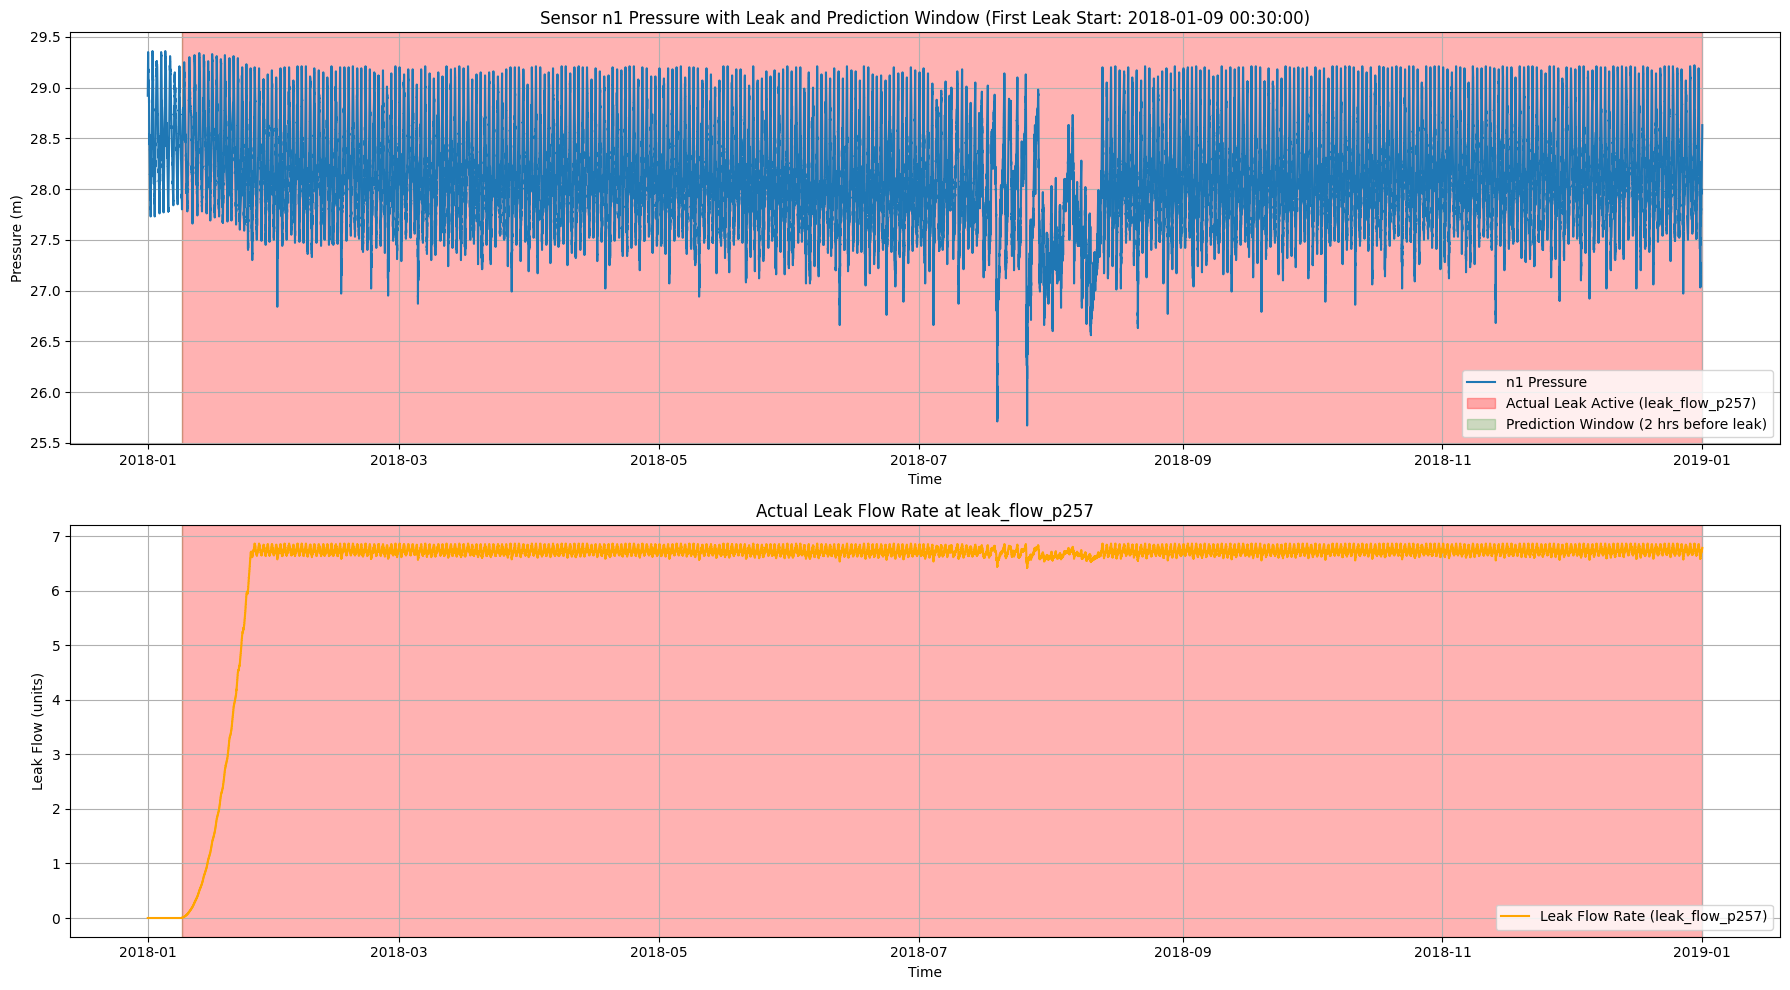

In [32]:
leak_event_plot('n1')

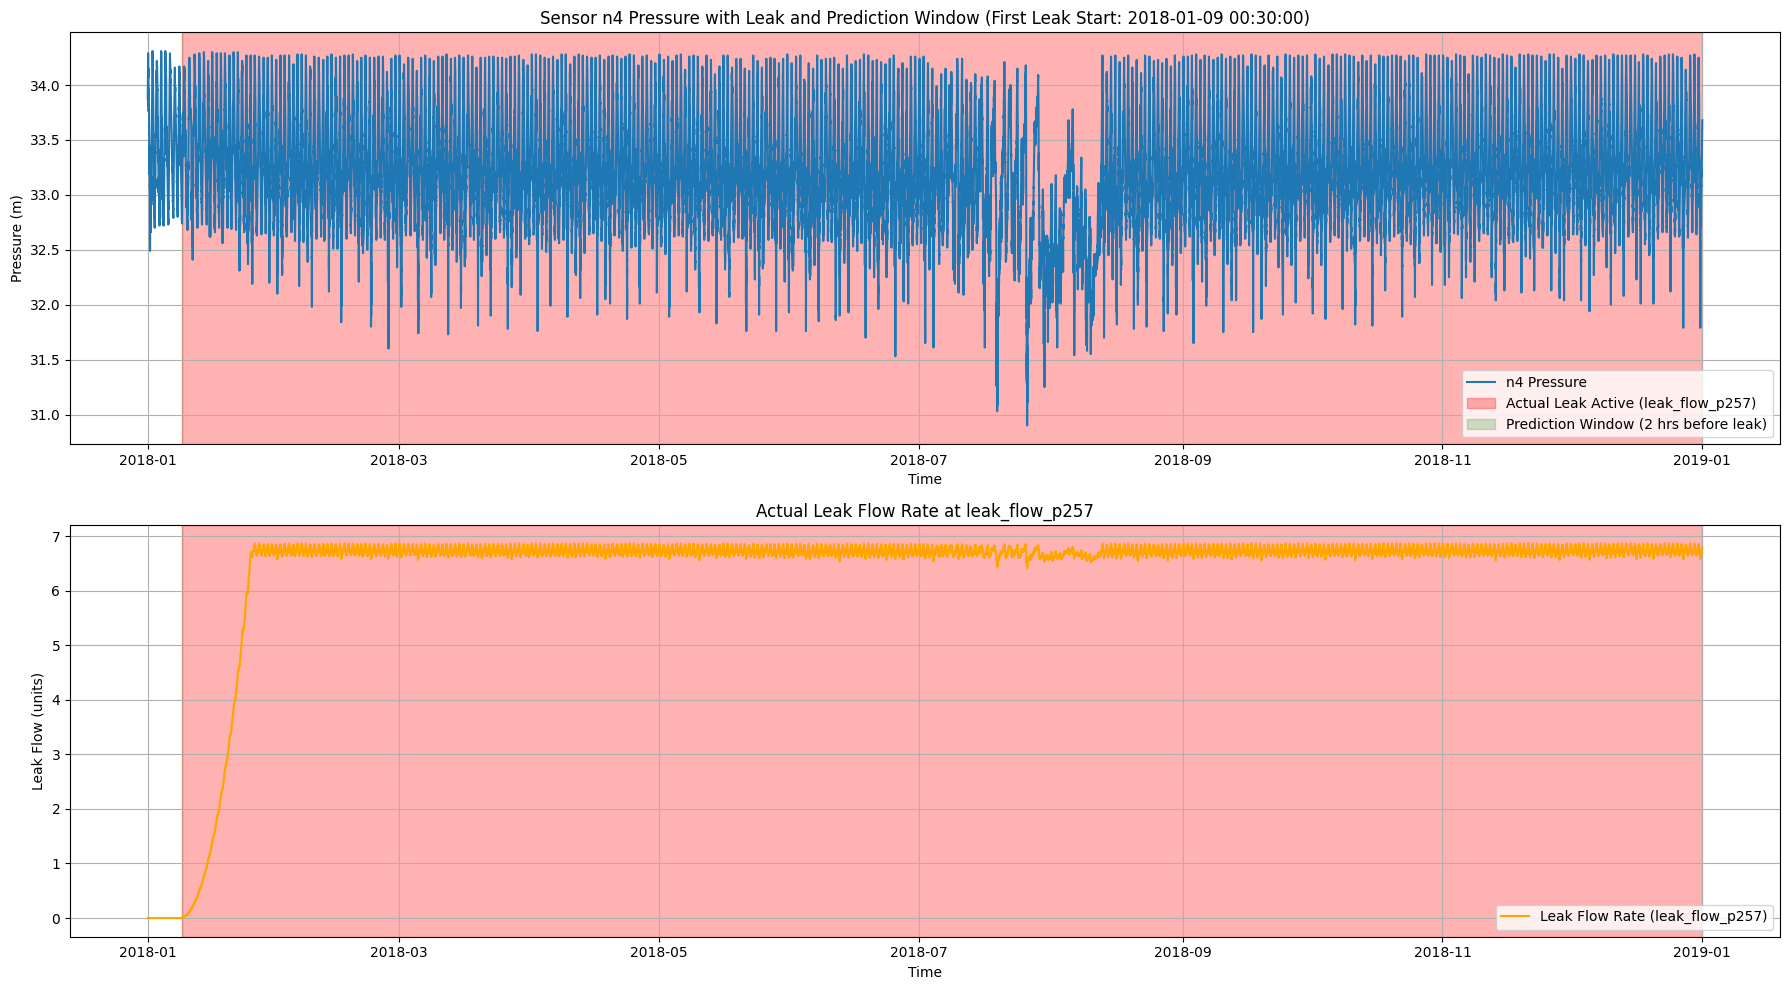

In [34]:
leak_event_plot('n4')

In [14]:
for index, row in leak_df.iterrows():
    start = row['start_time']
    end = row['end_time']
    leak_status[(leak_status.index >= start) & (leak_status.index <= end)] = 1

 Pipe-specific labeling